<a href="https://colab.research.google.com/github/everardogarciaf/portfolio/blob/main/Everardo_Garcia_Flores_senior_data_analyst_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Senior Analyst SQL Homework

You will be working with a fictious ecommerce dataset provided by Looker, hosted publicly on BigQuery https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce

Click this link for a sample query against this data set
https://console.cloud.google.com/bigquery?sq=258440106949:bfb3c07d98e6487ca028cd23ea86d361


You can use the Explorer as your scratch, but will write your final queries in this notebook and save the code and the results when you are done and send the link to your saved result back to data_team@cypress.io. 

You will write some SQL to return some specific summaries, then you will perform a free response analysis from a prompt. Spend no more than a few hours total completing this and email immediately when you're done

In [ ]:
# first you must authenticate with your Google account to query against the project you set up
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# prettier table display
%load_ext google.colab.data_table

#Query Assignment 1

Your partner in the marketing department wants a list of past customers to send a promotion. 
Fill in and run the cell below with a query that returns all user ids, first and last names and emails, who have ordered at least $20 lifetime, total over all their orders (go to the Explorer to browse the schema to find the necessary tables)

In [ ]:
%%bigquery --project cypress-hw
# replace 'your-project-id' with your personal project id where you linked the data set

##Query Assignment 1
##--Pull the total sale price for each order
WITH order_totals AS(
SELECT
    o.order_id
    , o.user_id
    , count(o.order_id) AS num_of_items
    , sum(oi.sale_price) AS order_total
FROM bigquery-public-data.thelook_ecommerce.orders o
LEFT JOIN bigquery-public-data.thelook_ecommerce.order_items oi
    ON oi.order_id = o.order_id
GROUP BY 1, 2
)

##--Find all users and their details, then get the sum of the total on all that user's orders
##--for users with a lifetime order total >= $20
SELECT
    u.id AS user_id
    , u.first_name
    , u.last_name
    , u.email
    , count(DISTINCT ot.order_id) AS num_of_orders
    , sum(order_total) AS lifetime_order_total
FROM bigquery-public-data.thelook_ecommerce.users u
LEFT JOIN order_totals ot
    ON ot.user_id = u.id
GROUP BY 1, 2, 3, 4
HAVING lifetime_order_total >= 20
ORDER BY 1

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,first_name,last_name,email,num_of_orders,lifetime_order_total
0,1,Elizabeth,Woodard,elizabethwoodard@example.org,1,56.920001
1,2,Kimberly,Kim,kimberlykim@example.net,1,29.990000
2,4,Anne,Brown,annebrown@example.net,1,28.990000
3,5,Douglas,Patterson,douglaspatterson@example.org,1,41.419998
4,7,Timothy,Collins,timothycollins@example.org,3,259.869999
...,...,...,...,...,...,...
73199,99991,Brad,Adkins,bradadkins@example.org,1,39.950001
73200,99992,Donald,Patel,donaldpatel@example.net,1,31.500000
73201,99995,Ruben,Price,rubenprice@example.com,1,53.950001
73202,99998,Donna,Lee,donnalee@example.com,1,38.400002


#Query Assignment 2

Your partner in finance and operations wants to know total profit last month (Nov 2022) by distribution center, to see if any of the distributions centers are performing much better than others. Total profit is the sale price of items sold from orders (ignore unsold inventory) minus the product cost of sold items found in the inventory table (for simplicity assume everything sold at full retail price, no discounts, returns or shrink). For extra credit, provide the month over month diff in the profit margin, from Oct 2022 to Nov 2022. 

In [ ]:
%%bigquery --project cypress-hw
# replace 'your-project-id' with your personal project id where you linked the data set

##Query Assignment 2
##--Find each ordered item and calculate its profit (sale_price - product_cost)
##--Assume the date on which the order was created is the finance order date
WITH all_ordered_items AS(
SELECT DISTINCT
    oi.id as order_item_id
    , o.order_id
    , o.user_id
    , i.product_id
    , i.product_distribution_center_id as dist_center_id
    , date_trunc(CAST(o.created_at AS DATE), MONTH) AS order_month
    , oi.sale_price
    , i.cost
    , oi.sale_price - i.cost AS item_profit
FROM bigquery-public-data.thelook_ecommerce.orders o
LEFT JOIN bigquery-public-data.thelook_ecommerce.order_items oi
    ON oi.order_id = o.order_id
LEFT JOIN bigquery-public-data.thelook_ecommerce.inventory_items i
    ON i.product_id = oi.product_id
# WHERE o.order_id = 8445
)

##--Find the monthly profits by distribution center
, monthly_profits AS (
SELECT
  a.order_month
  , a.dist_center_id
  , d.name
  , sum(a.item_profit) as total_profit
  , count(DISTINCT a.order_id) AS number_of_orders
FROM all_ordered_items a
LEFT JOIN bigquery-public-data.thelook_ecommerce.distribution_centers d
    ON d.id = a.dist_center_id
WHERE order_month BETWEEN '2022-06-01' AND '2022-11-30'
GROUP BY 1, 2, 3
ORDER BY 2, 1, total_profit DESC
)

##--Find the monthly profits from the previous month
, previous_month_profit AS (
SELECT
    m.dist_center_id
    , m.name AS dist_center_location
    , m.order_month
    , m.total_profit AS monthly_profit
    , LAG(m.total_profit, 1, 0) OVER(PARTITION BY m.dist_center_id ORDER BY m.dist_center_id, m.order_month) AS previous_month_profit
    , SUM(number_of_orders) AS total_orders
FROM monthly_profits m
GROUP BY 1, 2, 3, 4
ORDER BY 1
)

SELECT *
  , monthly_profit - previous_month_profit AS month_over_month_profit_diff
  , monthly_profit / total_orders AS avg_order_profit
FROM previous_month_profit p
WHERE order_month = '2022-11-01'

Query is running:   0%|          |

Downloading:   0%|          |

,dist_center_id,dist_center_location,order_month,monthly_profit,previous_month_profit,total_orders,month_over_month_profit_diff,avg_order_profit
0,1,Memphis TN,2022-11-01,820.335345,830.262647,27,-9.927301,30.382791
1,2,Chicago IL,2022-11-01,1044.660643,773.947082,29,270.713561,36.022781
2,3,Houston TX,2022-11-01,701.416070,858.380438,22,-156.964368,31.882549
3,4,Los Angeles CA,2022-11-01,594.329695,294.470137,23,299.859559,25.840422
4,5,New Orleans LA,2022-11-01,431.411091,355.548590,14,75.862501,30.815078
5,6,Port Authority of New York/New Jersey NY/NJ,2022-11-01,467.550019,650.070344,18,-182.520324,25.975001
6,7,Philadelphia PA,2022-11-01,473.472383,335.206492,17,138.265891,27.851317
7,8,Mobile AL,2022-11-01,363.868840,444.728869,12,-80.860029,30.322403
8,9,Charleston SC,2022-11-01,264.660761,181.155240,22,83.505521,12.030035
9,10,Savannah GA,2022-11-01,824.395789,221.222970,15,603.172819,54.959719


#Free Response Assignment

After looking at the profit margins of distribution centers, the VP of finance is very impressed with your skills and asks you look into the data more and see if you can find any more efficiencies for the distribution centers. Using your analytical best judgement, write one or more additional queries and show what you found. This should be doable 100% with SQL, but if you know Python or R for a chart you can use it in this section (this doesn't need machine learning or advanced stats techniques at all, this is pure exploratory mining). A few ideas to get started - how overstocked or understocked are they? is inventory well allocated across centers or not? Write some comments on any recommendations from your findings

In [ ]:
%%bigquery --project your-project-id

----------Do some exploratory work on distribution centers
---Location
---Order Frequency
---Monthly Inventory
---




TEST SECTION

In [126]:
#---------TEST AREA---------

%%bigquery --project cypress-hw
# replace 'your-project-id' with your personal project id where you linked the data set


#Efficiencies to look into:
#Shipping distance (what's the avg distance between the distribution center and the user?)
#Time to ship (when is the order created vs when is the order shipped?)
#Time in inventory (how long does a distribution center hold items in inventory?)
#Order profit by warehouse (Is the monthly average order profit trending up or down for a warehouse?)



##-----Fullfilment log for all ordered and fulfilled items
##It appears that items that are shipped are removed from inventory, so focusing on order fulfillment instead of inventory
WITH fulfillment_log AS (
SELECT
  i.id AS inventory_item_id
  , p.id AS product_id
  , o.order_id
  , oi.user_id
  , p.category
  , p.sku
  , p.distribution_center_id AS warehouse_id
  , p.cost
  , p.retail_price
  , p.retail_price - p.cost AS item_profit
  , CAST(oi.created_at AS DATE) AS order_date
  , CAST(oi.shipped_at AS DATE) AS shipping_date
  , date_diff(oi.shipped_at, oi.created_at, DAY) AS days_to_fulfill_order
  # , CASE WHEN oi.shipped_at IS NULL THEN IFNULL(date_diff(CURRENT_TIMESTAMP(), oi.created_at, DAY),0)
  #                               ELSE IFNULL(date_diff(oi.shipped_at, oi.created_at, DAY),0) END AS days_to_fulfill_order
  # , CAST(i.created_at AS DATE) AS enter_inventory_date
  # , CAST(i.sold_at AS DATE) AS exit_inventory_date
  # , CASE WHEN i.sold_at IS NULL THEN 0 ELSE 1 END AS is_sold
  # , CASE WHEN oi.shipped_at IS NULL THEN 0 ELSE 1 END AS is_shipped
  # , CASE WHEN i.sold_at IS NULL THEN IFNULL(date_diff(CURRENT_TIMESTAMP(), i.created_at, DAY),0)
  #                               ELSE IFNULL(date_diff(i.sold_at, i.created_at, DAY),0) END AS days_in_inventory
FROM bigquery-public-data.thelook_ecommerce.products p
LEFT JOIN bigquery-public-data.thelook_ecommerce.inventory_items i
    ON i.product_id = p.id
LEFT JOIN bigquery-public-data.thelook_ecommerce.order_items oi
    ON oi.inventory_item_id = i.id
LEFT JOIN bigquery-public-data.thelook_ecommerce.orders o
    ON o.order_id = oi.order_id
WHERE 1=1
  AND oi.order_id IS NOT NULL
  AND oi.shipped_at IS NOT NULL
  AND oi.created_at <= oi.shipped_at
  #There are items that were shipped but not sold. In a practical situation, I'd look to understand this further.
  #Given the constraints of the assignment, I'm ignoring anything without an order_id and focusing on the order and ship date
ORDER BY days_to_fulfill_order DESC
)


#monthly calendar to look at 2020 through EOY 2022
, calendar AS (
SELECT
  date,
  extract(month from date) as calendar_month,
  extract(year from date) as calendar_year,
from unnest(generate_date_array('2020-01-01', '2022-12-31', interval 1 month)) as date
order by date
)
,shipping_distances AS(
SELECT
    f.order_id
    , f.product_id
    , f.inventory_item_id
    , f.warehouse_id
    , ST_DISTANCE(
      ST_GEOGPOINT(d.longitude, d.latitude)
      , ST_GEOGPOINT(u.longitude,u.latitude)) /1000 shipping_distance_km
FROM fulfillment_log f
LEFT JOIN bigquery-public-data.thelook_ecommerce.distribution_centers d
    ON d.id = f.warehouse_id
LEFT JOIN bigquery-public-data.thelook_ecommerce.users u
    ON u.id = f.user_id

)

SELECT
    c.date AS calendar_month
    , i.warehouse_id

    # i.product_id
    # , i.category
    # , MAX(i.days_to_fulfill_order) AS longest_days_to_fulfill #--all 3 days, so ignoring
    # , MIN(i.days_to_fulfill_order) AS shortest_days_to_fulfill #--all 0 days, so ignoring
    , AVG(i.days_to_fulfill_order) AS avg_days_to_fulfill
    , count(*) AS total_fulfilled_items
    , AVG(i.cost) AS item_cost
    , AVG(i.item_profit) AS item_profit
    , AVG(i.retail_price) AS item_value
    , SUM(i.cost) AS cost_of_sold_items
    , SUM(i.retail_price) AS value_of_sold_items
    , SUM(i.item_profit) AS profit_of_sold_items
    , AVG(s.shipping_distance_km) AS avg_shipping_distance
FROM calendar c
LEFT JOIN fulfillment_log i ON c.date >= i.order_date
    AND c.date < coalesce(i.shipping_date, CURRENT_DATE())  #-- need coalesce in case the item hasn't been shipped yet
#-- the above join makes sure the inventory item was created before the current date and sold after the current date, or not sold yet
LEFT JOIN shipping_distances s
    ON s.inventory_item_id = i.inventory_item_id
GROUP BY 1, 2
# HAVING longest_days_to_fulfill > 0
  #  AND total_ordered_items > 1
ORDER BY 1, 2, total_fulfilled_items DESC, avg_days_to_fulfill DESC


Query is running:   0%|          |

Downloading:   0%|          |

,calendar_month,warehouse_id,avg_days_to_fulfill,total_fulfilled_items,item_cost,item_profit,item_value,cost_of_sold_items,value_of_sold_items,profit_of_sold_items,avg_shipping_distance
0,2020-01-01,1,1.750000,4,10.212545,12.247455,22.460001,40.850181,89.840002,48.989821,8780.769202
1,2020-01-01,2,2.000000,2,90.767501,169.232499,260.000000,181.535001,520.000000,338.464999,11175.757278
2,2020-01-01,3,1.500000,2,35.834151,52.160852,87.995003,71.668302,175.990005,104.321704,11797.459826
3,2020-01-01,4,1.333333,3,25.861827,22.951507,48.813334,77.585481,146.440002,68.854521,7107.811553
4,2020-01-01,5,1.000000,3,45.726700,52.853300,98.580001,137.180101,295.740002,158.559901,8431.578854
...,...,...,...,...,...,...,...,...,...,...,...
347,2022-12-01,6,1.500000,24,30.556070,30.528097,61.084167,733.345672,1466.020003,732.674331,7835.861444
348,2022-12-01,7,1.263158,19,37.901156,44.343581,82.244737,720.121957,1562.649994,842.528037,8330.729435
349,2022-12-01,8,1.571429,28,46.373373,44.088412,90.461786,1298.454457,2532.929995,1234.475538,8431.360584
350,2022-12-01,9,1.481481,27,23.189125,25.545319,48.734444,626.106366,1315.829990,689.723624,9567.527663


In [121]:
#---------TEST AREA---------

%%bigquery --project cypress-hw
# replace 'your-project-id' with your personal project id where you linked the data set


#Efficiencies to look into:
#Shipping distance (what's the avg distance between the distribution center and the user?)
#Time to ship (when is the order created vs when is the order shipped?)
#Time in inventory (how long does a distribution center hold items in inventory?)
#Order profit by warehouse (Is the monthly average order profit trending up or down for a warehouse?)



##-----Fullfilment log for all ordered and fulfilled items
##It appears that items that are shipped are removed from inventory, so focusing on order fulfillment instead of inventory
WITH fulfillment_log AS (
SELECT
  i.id AS inventory_item_id
  , p.id AS product_id
  , o.order_id
  , oi.user_id
  , p.category
  , p.sku
  , p.distribution_center_id AS warehouse_id
  , p.cost
  , p.retail_price
  , p.retail_price - p.cost AS item_profit
  , CAST(oi.created_at AS DATE) AS order_date
  , CAST(oi.shipped_at AS DATE) AS shipping_date
  , date_diff(oi.shipped_at, oi.created_at, DAY) AS days_to_fulfill_order

FROM bigquery-public-data.thelook_ecommerce.products p
LEFT JOIN bigquery-public-data.thelook_ecommerce.inventory_items i
    ON i.product_id = p.id
LEFT JOIN bigquery-public-data.thelook_ecommerce.order_items oi
    ON oi.inventory_item_id = i.id
LEFT JOIN bigquery-public-data.thelook_ecommerce.orders o
    ON o.order_id = oi.order_id
WHERE 1=1
  AND oi.order_id IS NOT NULL
  AND oi.shipped_at IS NOT NULL
  AND oi.created_at <= oi.shipped_at
  #There are items that were shipped but not sold. In a practical situation, I'd look to understand this further.
  #Given the constraints of the assignment, I'm ignoring anything without an order_id and focusing on the order and ship date
ORDER BY days_to_fulfill_order DESC
)


#monthly calendar to look at 2020 through EOY 2022
, calendar AS (
SELECT
  date,
  extract(month from date) as calendar_month,
  extract(year from date) as calendar_year,
from unnest(generate_date_array('2020-01-01', '2022-12-31', interval 1 month)) as date
order by date
)

,shipping_distances AS(
SELECT
    f.order_id
    , f.product_id
    , f.inventory_item_id
    , f.user_id
    , f.warehouse_id
    , d.longitude AS warehouse_long
    , d.latitude AS warehouse_lat
    , u.longitude AS shipping_long
    , u.latitude AS shipping_lat
    , ST_DISTANCE(
      ST_GEOGPOINT(d.longitude, d.latitude)
      , ST_GEOGPOINT(u.longitude,u.latitude)) /1000 shipping_distance_km
FROM fulfillment_log f
LEFT JOIN bigquery-public-data.thelook_ecommerce.distribution_centers d
    ON d.id = f.warehouse_id
LEFT JOIN bigquery-public-data.thelook_ecommerce.users u
    ON u.id = f.user_id

)

SELECT *
FROM shipping_distances s
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

,order_id,product_id,inventory_item_id,user_id,warehouse_id,warehouse_long,warehouse_lat,shipping_long,shipping_lat,shipping_distance_km
0,29706,27569,116394,23717,1,-89.9711,35.1174,-49.279952,-28.770091,8287.004998
1,42264,27569,165433,33747,1,-89.9711,35.1174,4.465146,51.034978,7333.623120
2,63667,27569,249249,50853,1,-89.9711,35.1174,-93.216658,38.704132,492.186109
3,84065,27569,329128,67177,1,-89.9711,35.1174,108.945766,34.246548,12055.309829
4,108737,27569,425971,86794,1,-89.9711,35.1174,127.145619,37.489682,11079.330121
5,28036,27445,109721,22390,1,-89.9711,35.1174,121.540803,31.292781,11929.458948
6,39915,27445,156242,31899,1,-89.9711,35.1174,2.184272,41.411192,7678.832740
7,72184,27445,282573,57647,1,-89.9711,35.1174,113.083519,29.405158,12444.478452
8,31826,27457,124626,25415,1,-89.9711,35.1174,-90.378026,40.944671,648.941008
9,39673,27457,155365,31706,1,-89.9711,35.1174,121.424381,31.417485,11921.995248


In [124]:
%%bigquery --project cypress-hw


SELECT *
FROM bigquery-public-data.thelook_ecommerce.users u
WHERE u.id = 23717

Query is running:   0%|          |

Downloading:   0%|          |

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,23717,Justin,Baker,justinbaker@example.net,66,M,Santa Catarina,24262 Austin Walk,88820-000,Balneário Rincão,Brasil,-28.770091,-49.279952,Search,2019-04-23 08:22:00+00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = df

print(data.head())
print(data.shape)
print(data.info)

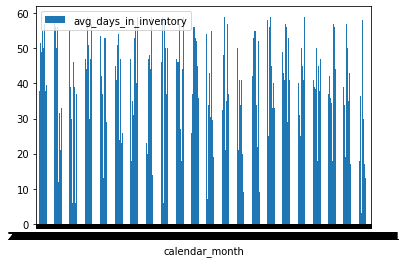

In [65]:


ax = data.plot.bar(x="calendar_month", y="avg_days_in_inventory", rot=0)
                   #.value_counts().plot(kind="bar", figsize=(14,6))